#**Importation des bibliothèques**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import requests
import zipfile
import io

# Download necessary NLTK data (only need to run this once)
nltk.download('stopwords')

# Make graphs look nice
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Chargement des données**

In [13]:
from datasets import load_dataset

# Charger le dataset
dataset = load_dataset("dbarbedillo/SMS_Spam_Multilingual_Collection_Dataset")

# Get original column names
original_columns = dataset["train"].column_names

# Sélectionner uniquement les colonnes des textes en français et labels (ham/spam)
# Et supprimer toutes les autres colonnes d'origine
fr_data = dataset["train"].map(lambda x: {"text": x["text_fr"], "labels": x["labels"]}, remove_columns=original_columns)

# Retirer les entrées vides
fr_data = fr_data.filter(lambda x: x["text"] is not None and x["text"].strip() != "")

# Vérifier
print(len(fr_data))

# Afficher les 5 premiers exemples
for i in range(5):
    print(fr_data[i])
    print("-" * 50)

5572
{'labels': 'ham', 'text': "Allez jusqu'à Jurong point, fou.. Disponible seulement dans bugis n grand monde la e buffet... Cine il y a eu plus..."}
--------------------------------------------------
{'labels': 'ham', 'text': "J'ai fait une blague sur le wif u oni..."}
--------------------------------------------------
{'labels': 'spam', 'text': "Entrée libre dans 2 a wkly comp pour gagner FA Cup final tkts 21 mai 2005. Texte FA à 87121 pour recevoir la question d'entrée(std txt rate)T&C's appliquer 08452810075over18's"}
--------------------------------------------------
{'labels': 'ham', 'text': 'U dun dit si tôt hor... U c déjà dire alors...'}
--------------------------------------------------
{'labels': 'ham', 'text': "Non, je ne pense pas qu'il va à usf, il vit dans le coin."}
--------------------------------------------------


# **Analyse exploratoire des données (AED)**

labels
ham     4825
spam     747
Name: count, dtype: int64


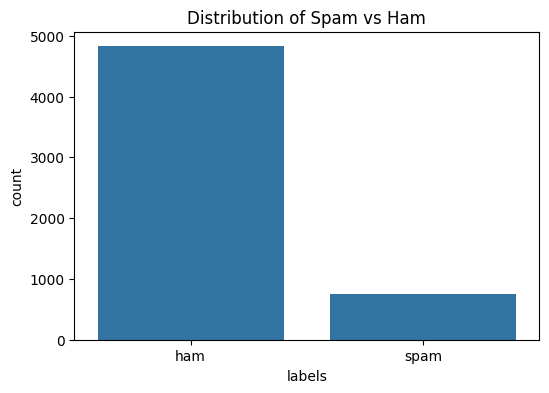

In [14]:
import pandas as pd

# Convertir le dataset en DataFrame pandas pour une manipulation plus facile
fr_data_df = fr_data.to_pandas()

print(fr_data_df['labels'].value_counts())

# Visualize it
plt.figure(figsize=(6,4))
sns.countplot(x='labels', data=fr_data_df)
plt.title("Distribution of Spam vs Ham")
plt.show()

# **Ingénierie des caractéristiques :**

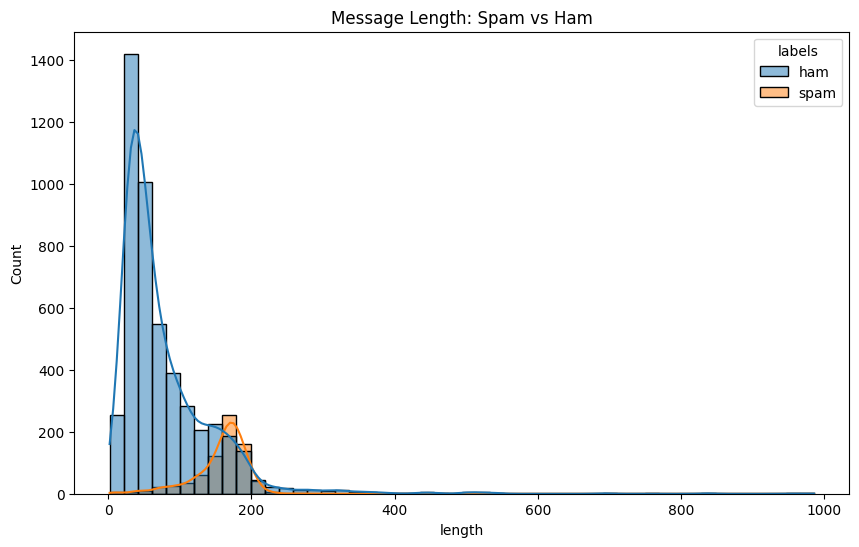

In [15]:
# Create a new column 'length'
fr_data_df['length'] = fr_data_df['text'].apply(len)

# Plot the distribution
plt.figure(figsize=(10,6))
sns.histplot(data=fr_data_df, x='length', hue='labels', bins=50, kde=True)
plt.title("Message Length: Spam vs Ham")
plt.show()

#**Normalisation**


In [16]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)        # URLs
    text = re.sub(r"\S+@\S+", " ", text)        # Emails
    text = re.sub(r"\d+", " ", text)            # Nombres
    text = re.sub(r"[^\w\s]", " ", text)        # Ponctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

fr_data_df["clean_text"] = fr_data_df["text"].apply(clean_text)

fr_data_df[["text", "clean_text"]].head()


,text,clean_text
0,"Allez jusqu'à Jurong point, fou.. Disponible s...",allez jusqu à jurong point fou disponible seul...
1,J'ai fait une blague sur le wif u oni...,j ai fait une blague sur le wif u oni
2,Entrée libre dans 2 a wkly comp pour gagner FA...,entrée libre dans a wkly comp pour gagner fa c...
3,U dun dit si tôt hor... U c déjà dire alors...,u dun dit si tôt hor u c déjà dire alors
4,"Non, je ne pense pas qu'il va à usf, il vit da...",non je ne pense pas qu il va à usf il vit dans...


In [17]:
from sklearn.model_selection import train_test_split

X = fr_data_df["clean_text"]
y = fr_data_df["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 4457
Test size : 1115


# **Vectorisation** : TF-IDF + N-GRAM

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Get French stop words from NLTK
french_stop_words = stopwords.words('french')

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # unigram + bigram
    min_df=2,
    max_df=0.9,
    stop_words=french_stop_words # Use the list of French stop words
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Shape TF-IDF train:", X_train_tfidf.shape)
print("Shape TF-IDF test :", X_test_tfidf.shape)


Shape TF-IDF train: (4457, 7914)
Shape TF-IDF test : (1115, 7914)


Il est préférable de maintenir l'ordre actuel des opérations, où les données sont d'abord divisées en ensembles d'entraînement et de test, puis la vectorisation TF-IDF est appliquée. Cette approche est cruciale pour éviter la fuite de données (data leakage).

Si nous vectorisions l'ensemble du dataset avant de le diviser, le modèle TF-IDF apprendrait du vocabulaire et des fréquences de termes à partir des données de test, ce qui compromettrait l'intégrité de l'évaluation du modèle. La méthode actuelle, où tfidf.fit_transform() est appliquée sur X_train et tfidf.transform() sur X_test, garantit que le modèle ne voit les données de test qu'au moment de l'évaluation, ce qui donne une mesure plus fiable de ses performances.

Définition du modèle et Entrainement

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Instantiate the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Calculate Accuracy for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Calculate F1-score for Random Forest (weighted average for imbalanced classes)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"F1-Score: {f1_rf:.4f}")

Random Forest Accuracy: 0.9767
Random Forest Weighted F1-Score: 0.9757


Vérification de la performance avec matrice de confusion

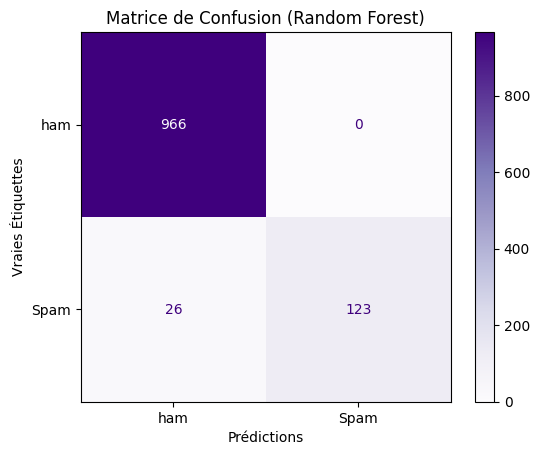

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define French labels
french_labels = ['ham', 'Spam']

# Calculate the confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)

# Display the confusion matrix with French labels and axis labels
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=french_labels)
disp_rf.plot(cmap=plt.cm.Purples) # Using a different colormap for distinction
plt.title("Matrice de Confusion (Random Forest)")
plt.xlabel("Prédictions")
plt.ylabel("Vraies Étiquettes")
plt.show()

Test

In [34]:
def predict_spam_ham_rf(message):
    # Clean the message using the previously defined clean_text function
    clean_msg = clean_text(message)

    # Transform the cleaned message using the fitted TF-IDF vectorizer
    # tfidf was defined in cell TenJ5rUl8zWD
    message_vector = tfidf.transform([clean_msg])

    # Predict using the trained Random Forest model
    # rf_model was defined in cell 03fa15ca
    prediction = rf_model.predict(message_vector)

    return prediction[0]

# Test with custom messages using the Random Forest model
print("\n--- Test réel avec Random Forest ---")

input_message_rf_1 = "Félicitations! Vous avez gagné une carte cadeau de 1000 euros. Appelez maintenant pour réclamer."
prediction_rf_1 = predict_spam_ham_rf(input_message_rf_1)
print(f"Message test: '{input_message_rf_1}'")
print(f"Prédiction (Random Forest): {prediction_rf_1}")

input_message_rf_2 = "URGENT – Problème de sécurité sur votre compte.Cher client,Nous avons détecté une activité suspecte sur votre compte bancaire.Veuillez confirmer vos informations immédiatement pour éviter la suspension.👉 Cliquez ici : www.securite-compte-verif.com"
prediction_rf_2 = predict_spam_ham_rf(input_message_rf_2)
print(f"Message test: '{input_message_rf_2}'")
print(f"Prédiction (Random Forest): {prediction_rf_2}")

input_message_rf_3 = "Rendez-vous à 14h pour notre réunion."
prediction_rf_3 = predict_spam_ham_rf(input_message_rf_3)
print(f"Message test: '{input_message_rf_3}'")
print(f"Prédiction (Random Forest): {prediction_rf_3}")


--- Test réel avec Random Forest ---
Message test: 'Félicitations! Vous avez gagné une carte cadeau de 1000 euros. Appelez maintenant pour réclamer.'
Prédiction (Random Forest): spam
Message test: 'URGENT – Problème de sécurité sur votre compte.Cher client,Nous avons détecté une activité suspecte sur votre compte bancaire.Veuillez confirmer vos informations immédiatement pour éviter la suspension.👉 Cliquez ici : www.securite-compte-verif.com'
Prédiction (Random Forest): spam
Message test: 'Rendez-vous à 14h pour notre réunion.'
Prédiction (Random Forest): ham
